In [5]:
using Distributions
using Plots
using LaTeXStrings
using LinearAlgebra
using Colors
using JLD
using Parameters
using Random
import ProgressMeter
using AIDA

┌ Info: Precompiling AIDA [02ab3c64-7f6e-4624-92b1-4056b28faae1]
└ @ Base loading.jl:1317
┌ Info: Precompiling SIMDDualNumbers [3cdde19b-5bb0-4aaf-8931-af3e248e098b]
└ @ Base loading.jl:1317


### Parameters

In [55]:
# Dimensionality of input. We use 2 parameters
ndims = 2
# How many points to seed the agent with
npoints = 1

# Generate random queries for initial seed and get user feedback
x1 = rand(ndims, npoints)
y1 = generate_user_response.(eachcol(x1))

# Set up the grid to search over
n_steps = 50 # Number of cells per axis
grid_axis = LinRange(0, 1, n_steps)
grid = Iterators.product(grid_axis, grid_axis) # make the grid

# Initial hyperparameters for the kernel
σ = 0.5
l = 0.5

# Number of timesteps to run
T = 80

# current keeps track of the point the agent is at.
# We use it to prevent the agent proposing identical gains on consequtive trials 
current = (0.5, 0.5)

# bookkeeping
efe_grids, epi_grids, inst_grids, idxs = [],[],[],[]
;

### Run a single experiment and save results

In [56]:
p = ProgressMeter.Progress(T, 1)
Random.seed!(1)
let x1 = x1, y1 = y1, current = current, σ = σ, l = l, idxs = idxs
    for t ∈ 1:T
        # Get a new proposal (x2), grids of epistemic (epi) an instrumental value (inst), 
        # grid of EFE (value) and the position to move to (idx)
        epi_grid, inst_grid = get_new_decomp(grid, x1, y1, σ, l)

        # Compute the EFE grid
        value_grid = epi_grid + inst_grid
        # Ensure that we propose a new trial and not the same one twice in a row
        value_grid[collect(grid).==[(current[1], current[2])]] .= Inf

        # Find the minimum and try it out
        idx = argmin(value_grid)
        x2 = collect(grid)[idx]

        # Update current point after testing
        current = (x2[1], x2[2])

        # Get some user feedback
        y1 = vcat(y1, generate_user_response(collect(x2)))
        x1 = hcat(x1, collect(x2))

        # Optimize hyperparams every 5th iteration
        if t % 5 == 0
            σ, l = optimize_hyperparams(x1, y1, [0.5, 0.5])
        end

        # bookkeeping
        append!(efe_grids, value_grid)
        append!(epi_grids, epi_grid)
        append!(inst_grids, inst_grid)
        idxs = vcat(idxs, idx)
        
        ProgressMeter.next!(p)
    end
    println("All done, saving results")
    save("verification-jlds/agent_experiment.jld", "efe_grids", efe_grids, "epi_grids", epi_grids, "inst_grids", inst_grids, "responses", y1, "points", x1, "idxs", idxs)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:05:41


All done, saving results


# Batch  experiments
FYI, this takes a long time to run.

In [7]:
# Dimensionality of input. We use 2 gains
ndims = 2
# Number of points to seed each agent with at the start of a run
npoints = 1
# Number of timesteps for each experiment
T = 80

# Number of experiments to run. The paper uses 2x40
n_runs = 80

# Set up the grid to search over
n_steps = 50 # Number of cells per axis
grid_axis = LinRange(0, 1, n_steps)
grid = Iterators.product(grid_axis, grid_axis) # make the grid

# Bookkeeping
efe_vals = zeros(n_runs, T)
epi_vals = zeros(n_runs, T)
inst_vals = zeros(n_runs, T)
responses = ones(n_runs, T + 1)
traj = zeros(n_runs, 2, T)
;

In [61]:
# Runs experiments in a loop
p = ProgressMeter.Progress(n_runs*T, 1)
Random.seed!(666)
for run ∈ 1:n_runs
    #println("starting run: ", run)
    x1 = rand(ndims, npoints) # Start the agent at a random location
    y1 = generate_user_response.(eachcol(x1)) 

    # Initial hyperparameters for the kernel
    σ = 0.5
    l = 0.5

    # Keep track of last point visited
    current = (0.5, 0.5)

    let x1 = x1, y1 = y1, current = current, σ = σ, l = l
        for t ∈ 1:T
            # Get new proposal (x2) and epistemic/instrumental value at the queried point
            epi_grid, inst_grid = get_new_decomp(grid, x1, y1, σ, l)

            # Compute the EFE grid
            value_grid = epi_grid + inst_grid
            # Ensure that we propose a new trial and not the same one twice in a row
            value_grid[collect(grid).==[(current[1], current[2])]] .= Inf

            # Find the minimum and try it out
            idx = argmin(value_grid)
            x2 = collect(grid)[idx]

            # Update current point after testing
            current = (x2[1], x2[2])

            # Get some user feedback
            y1 = vcat(y1, generate_user_response(collect(x2)))
            x1 = hcat(x1, collect(x2))

            # Optimize hyperparams every 5th iteration
            if t % 5 == 0
                σ, l = optimize_hyperparams(x1, y1, [0.5,0.5])
            end

            # Store results
            epi_vals[run, t] = epi_grid[idx]
            inst_vals[run, t] = inst_grid[idx]
            traj[run, :, t] .= x2
            ProgressMeter.next!(p)
        end
        # Save user responses
        responses[run, :] .= y1
    end        
end
efe_vals = epi_vals + inst_vals
println("All done, saving data")
save("verification-jlds/agent_batch_experiment.jld", "efe_vals", efe_vals, "epi_vals", epi_vals, "inst_vals", inst_vals, "traj", traj, "responses", responses)

Progress: 100%|█████████████████████████████████████████| Time: 0:06:35


All done, saving data


## PGFPLOTS

In [3]:
using PGFPlotsX
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

### Heatmap

In [58]:
experiment = JLD.load("verification-jlds/agent_experiment.jld")

efe_grids = experiment["efe_grids"]
efe_grids = reshape(efe_grids, n_steps,n_steps, T);
efe_grids[efe_grids .== Inf] .= maximum(efe_grids[efe_grids .!= Inf])

epi_grids = experiment["epi_grids"]
epi_grids = reshape(epi_grids, n_steps,n_steps, T);

inst_grids = experiment["inst_grids"]
inst_grids = reshape(inst_grids, n_steps,n_steps, T);

idxs = experiment["idxs"]
points = experiment["points"]
resp = experiment["responses"];

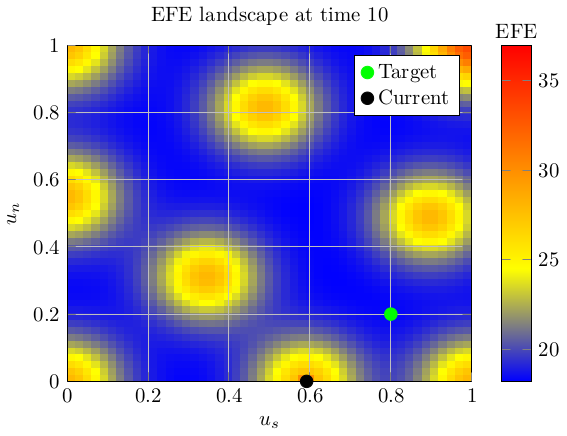

In [78]:
index = 10 # timepoint to visualize
x = y = grid_axis

target = [[0.8], [0.2]]
current = map(x -> [first(x)], points[:,index])


axis1 = @pgf Axis(
    {
        title="EFE landscape at time $(index)",
        xlabel=L"u_s",
        ylabel=L"u_n",
        zlabel="hz",
        legend_pos = "north east",
        legend_cell_align="{left}",
        grid = "major",
        view = (0, 90),
        colorbar,
        "colormap/hot",
        colorbar_style={"xlabel=EFE, xticklabel pos=upper"}
    },
    Plot({only_marks, color="green", mark_size=3.0, mark="*"}, 
    Coordinates(target...)), LegendEntry("Target"),
    Plot({only_marks, color="black", mark_size=3.0, mark="*"}, 
    Coordinates(current...)), LegendEntry("Current"),
    Plot3(
        {
            surf,
            shader = "flat",
        },
        Coordinates(x, y, efe_grids[:, :, index]))
    )
# pgfsave("tmp/heatmap_$(index).svg", axis1)
# pgfsave("tikz/heatmap_$(index).tikz", axis1)

### EFE plots

In [63]:
# Get the values of queried points for all time steps
epi_mins = [epi_grids[:,:,i][idxs[i]] for i in 1:T]
inst_mins = [inst_grids[:,:,i][idxs[i]] for i in 1:T];

In [77]:
# TODO: (albert) I've changes Negative Information Gain to Information gain
plt_agent = @pgf GroupPlot(
    # group plot options
    {
        width="15cm", height="8cm",

        group_style = {
            group_size = "2 by 1",
            horizontal_sep = "1.5cm",
        },
    },
    # first
    {xlabel=L"t",
           ylabel="value",
           legend_pos = "north east",
           legend_cell_align="{left}",
           grid = "major",
        #    title="TODO: TITLE",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot(
        {no_marks,color="blue"}, Coordinates(collect(1:T), -epi_mins)
    ), LegendEntry("Information gain"),
    # second
    {xlabel=L"t",
           legend_pos = "north east",
           legend_cell_align="{left}",
           grid = "major",
        #    title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot(
        {no_marks,color="blue"}, Coordinates(collect(1:T), inst_mins)
    ), LegendEntry("Utility drive"),
)
pgfsave("tmp/grouped_agent.svg", plt_agent)
# pgfsave("tikz/grouped_agent.tikz", plt_agent)

In [79]:
# Plot of user pref function
n_ticks = 100 # How finely to grid the preference function

x = y = LinRange(0,1,n_ticks)

z = zeros(n_ticks,n_ticks);
for i in 1:n_ticks
    for j in 1:100
	z[i,j] = generate_user_response([i/n_ticks,j/n_ticks],binary=false)
    end
end;

pref_map= @pgf Axis(
    {
        title="User preference function",
        xlabel=L"u_s",
        ylabel=L"u_n",
        zlabel="hz",
        legend_pos = "north east",
        legend_cell_align="{left}",
        grid = "major",
        view = (0, 90),
        colorbar,
        "colormap/hot",
        colorbar_style={"xlabel=θ, xticklabel pos=upper"}
    },
    Plot3(
        {
            surf,
            shader = "flat",
        },
        Coordinates(x, y, z))
    )
pgfsave("tmp/pref_map.svg", pref_map)
# pgfsave("tikz/pref_map.tikz", pref_map)

In [ ]:
### Batch Plots

In [71]:
using Colors
# For the paper, experiments were done in 2 batches of 40
experiment = JLD.load("verification-jlds/agent_experiment_batch.jld")


# Heatmap of positive user appraisals
resp = experiment["responses"]

# Histogram of first index of positive response
idxs = [findfirst( isequal(1),resp[i,:]) for i in 1:size(resp)[1]]
idxs[isnothing.(idxs)] .= 82 # If the agent didn't get a positive response, set it to 82. 
                             # Each experiment has 80 trials + 1 seed
;

In [72]:
y = 1:T 
x = 1:T+1

resp_map= @pgf Axis(
    {
        title="Positive Appraisals",
        xlabel="Time Index",
        ylabel="Agent number",
        grid = "minor",
        view = (0, 90), 
        colormap = "{blackwhite}{color=(black) color=(yellow)}"
    },
    Plot3(
        {
            surf,
            shader = "flat corner",
        },
        Coordinates(x, y, resp')),
    )
pgfsave("tmp/resp_map.svg", resp_map)
#pgfsave("tikz/resp_map.tikz", resp_map)

In [75]:
using StatsBase: Histogram, fit, normalize
h = fit(Histogram, Float64.(idxs), nbins=100, closed = :left)

shift = 2
plt_histogram = @pgf Axis(
    {
        xlabel="\\small{Time Index}",
        ylabel="\\small{Number of Postive responses}",
        title="Ensemble Performance",
        ticklabel_style={"font=\\tiny"},
        yticklabel_style={
        "/pgf/number format/fixed,
        /pgf/number format/precision=0"
        },
        grid="major",
        yminorgrids=true,
        tick_align="outside",
        xtick=range(0, 80; length=5),
        ytick=range(1, 18; length=9),
        xmin =0.0,
        xmax=maximum(idxs)+shift,
        scaled_y_ticks = false,
    },
    Plot({"ybar interval", fill="blue!85", "forget plot"}, Table(h)))
pgfsave("tmp/ensemble_perf.svg", plt_histogram)
# pgfsave("tikz/ensemble_perf.tikz", plt_histogram)

In [76]:
# Average EFE of ensemble as a function of time
efes = experiment["efe_vals"]
efe_means = mean(efes,dims=1)[:]
avg_efe = @pgf Axis(
    {
        title="Average EFE of ensemble",
        xlabel="Time Index",
        ylabel="EFE",
        grid = "minor",
        view = (0, 90), 
        colormap = "{blackwhite}{color=(black) color=(yellow)}",
        no_marks,
        x_post_scale = 1.5
    },
    Plot(Coordinates(1:T, efe_means))
)
pgfsave("tmp/avg_efe.svg", avg_efe)
# pgfsave("tikz/avg_efe.tikz", avg_efe)